In [22]:
versioninfo()

Julia Version 1.5.3
Commit 788b2c77c1 (2020-11-09 13:37 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.7.0)
  CPU: Intel(R) Core(TM) i5-8210Y CPU @ 1.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-9.0.1 (ORCJIT, skylake)


In [23]:
using Interpolations
using Printf
using Optim
using PyPlot
using LinearAlgebra
using HDF5

In [24]:
ntimes = 1000
maxt = 100.0
temps = [0.1, 0.2, 0.3]
times = collect(range(0.0, maxt, length=ntimes))
taus = [0.5*maxt, 0.1*maxt, 0.01*maxt]
lambda = 0.1

g(x) = exp(-x^1.5)
m(t, tau) = tau^(-lambda) * g(t/tau)

m (generic function with 1 method)

In [25]:
println("taus ", taus)

taus [50.0, 10.0, 1.0]


In [26]:
# m_data: (ntimes, ntemps)
newaxis = [CartesianIndex()]
m_data = m.(times[:,newaxis], taus[newaxis,:])

1000×3 Array{Float64,2}:
 0.676243   0.794328     1.0
 0.676183   0.793533     0.968826
 0.676072   0.792081     0.914318
 0.675929   0.790205     0.848264
 0.675759   0.787989     0.776187
 0.675566   0.785484     0.701816
 0.675354   0.782722     0.627849
 0.675122   0.779731     0.556248
 0.674874   0.77653      0.488402
 0.67461    0.773137     0.425242
 0.67433    0.769566     0.367327
 0.674037   0.765829     0.314924
 0.67373    0.761938     0.26807
 ⋮                       
 0.041876   2.4695e-14   0.0
 0.0416995  2.35557e-14  0.0
 0.0415236  2.24685e-14  0.0
 0.0413484  2.14309e-14  0.0
 0.0411738  2.04407e-14  0.0
 0.0409999  1.94959e-14  0.0
 0.0408266  1.85942e-14  0.0
 0.040654   1.77339e-14  0.0
 0.040482   1.69129e-14  0.0
 0.0403106  1.61296e-14  0.0
 0.0401399  1.53822e-14  0.0
 0.0399699  1.46691e-14  0.0

In [27]:
# Add noise
m_data .+= 0.001 * randn(size(m_data))

1000×3 Array{Float64,2}:
 0.677506    0.79487       1.00026
 0.67726     0.791914      0.968902
 0.678015    0.793727      0.914846
 0.674428    0.789946      0.848094
 0.675543    0.788582      0.775673
 0.674559    0.784576      0.701547
 0.675653    0.782674      0.62872
 0.674707    0.780342      0.555725
 0.674903    0.775823      0.487215
 0.675489    0.773107      0.425425
 0.67398     0.771004      0.366579
 0.673765    0.765039      0.316083
 0.673693    0.762728      0.268488
 ⋮                        
 0.0432329   0.000620871  -9.20873e-6
 0.0410427   0.000900871   0.000405147
 0.0402994  -0.00106302   -0.000431479
 0.041629    0.000280959   0.0012734
 0.0402399   0.000367838  -0.000753325
 0.04154    -0.00222721   -0.00191707
 0.0401234  -0.000185941   0.00115292
 0.0414893  -0.000884334  -0.00113069
 0.0412647  -0.0014626    -0.000876318
 0.0400711  -0.00185165   -0.00105092
 0.0408784   0.000177363   0.000462251
 0.0400893   0.000871786  -0.0017992

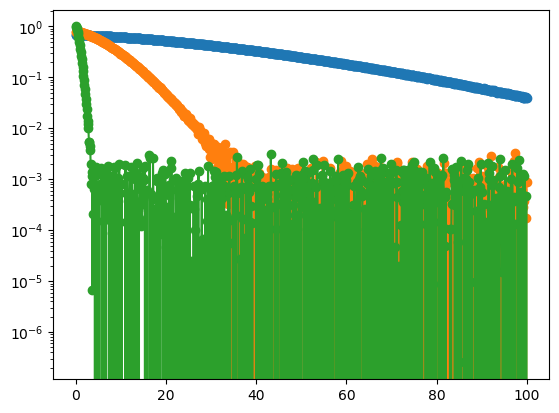

In [28]:
for it in eachindex(temps)
    plt.semilogy(times, m_data[:, it], marker="o")
end

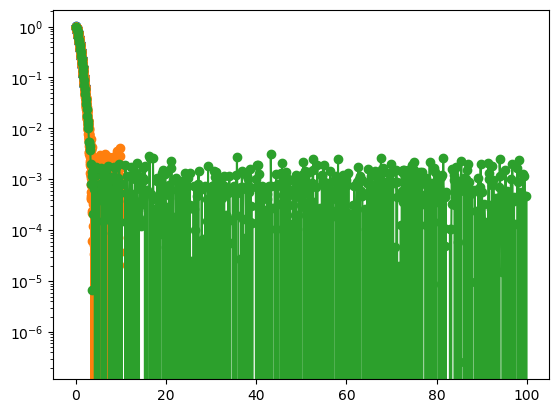

In [29]:
for it in eachindex(temps)
    plt.semilogy(times ./ taus[it], (taus[it]^lambda) * m_data[:, it], marker="o")
    #println((taus[it]^lambda) * m_data[:, it])
end

In [30]:
"""
params: [tau1, tau2, ...]
"""
function cost(params)
    taus = params
    nx_smpl = 10
    x_u = minimum(times[end] ./ taus)
    x_l = maximum(times[1] ./ taus)
    xs_smpl = range(x_l, x_u, length=nx_smpl)
    g_intpl = zeros((nx_smpl, length(temps)))
    for it in eachindex(temps)
        tau = taus[it]
        xs = times ./ tau
        g_data = tau^lambda * m_data[:, it]
        itp = LinearInterpolation(xs, g_data)        
        g_intpl[:, it] = itp.(xs_smpl)
    end
    g_mean = sum(g_intpl, dims=2) ./ length(temps)
    norm(g_intpl .- g_mean[:, newaxis])^2 /  norm(g_mean)^2
end

cost

In [31]:
res = Optim.optimize(cost, taus)
res

 * Status: success

 * Candidate solution
    Final objective value:     9.275841e-06

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    36
    f(x) calls:    76


In [32]:
taus_opt = Optim.minimizer(res)

3-element Array{Float64,1}:
 50.92999678348086
 10.188096527472625
  1.020207438293793

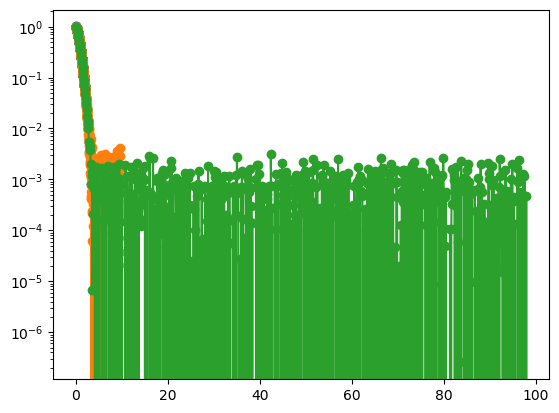

In [33]:
for it in eachindex(temps)
    plt.semilogy(times ./ taus_opt[it], (taus_opt[it]^lambda) * m_data[:, it], marker="o")
    #println((taus[it]^lambda) * m_data[:, it])
end